In [35]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [53]:
def trainer(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     for i in range(train_batches): 
    img_batch1, gt_bboxes_batch1, gt_classes_batch1 = train_dataloader
    img_batch2, gt_bboxes_batch2, gt_classes_batch2 = train_dataloader
    img_batch = torch.stack([img_batch1, img_batch2], dim=0)
    gt_bboxes_batch = torch.stack([gt_bboxes_batch1, gt_bboxes_batch2], dim=0)
    gt_classes_batch = torch.stack([gt_classes_batch1, gt_classes_batch2], dim=0) 

    model.train()
    loss_list = []
    pred_classes = []

    for i in tqdm(range(n_epochs)):
        total_loss = 0
        # forward pass
        loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print('tot:', total_loss)

        loss_list.append(total_loss)
    proposals_final, conf_scores_final, classes_final = model.inference(img_batch)
    
#     j = train_batches + 1 
#     pred_classes = []
#     gt_classes = []
#     for i in range(j, 228): 
#         img_batch1, gt_bboxes_batch1, gt_classes_batch1 = train_dataloader[i]
#         img_batch2, gt_bboxes_batch2, gt_classes_batch2 = train_dataloader[i]
#         img_batch = torch.stack([img_batch1, img_batch2], dim=0)
#         gt_bboxes_batch = torch.stack([gt_bboxes_batch1, gt_bboxes_batch2], dim=0)
#         gt_classes_batch = torch.stack([gt_classes_batch1, gt_classes_batch2], dim=0)
        
#         for k in gt_classes_batch1[0]: 
#             if k != -1:
#                 gt_classes.append(idx_2_n[k])

#         proposals_final, conf_scores_final, classes_final = TSD.inference(mini.img_batch)
        
#         for k in classes_final[0]: 
#             if k != -1:
#                 pred_classes.append(idx_2_n[k])

    return loss_list, classes_final, proposals_final, conf_scores_final


def project_bboxes( bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
        assert mode in ['a2p', 'p2a']

        batch_size = bboxes.size(dim=0)
        proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4).to(torch.float)
        invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

        if mode == 'a2p':
            # activation map to pixel image
            proj_bboxes[:, :, [0, 2]] *= width_scale_factor
            proj_bboxes[:, :, [1, 3]] *= height_scale_factor
        else:
            # pixel image to activation map
            proj_bboxes[:, :, [0, 2]] /= width_scale_factor
            proj_bboxes[:, :, [1, 3]] /= height_scale_factor

        proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
        proj_bboxes.resize_as_(bboxes)

        return proj_bboxes
    
def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
    
    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1

In [49]:
# def scale_boxes( truth_boxes, og_width, og_height, target_size):
#     target_width, target_height = target_size

#     wsf = target_width / og_width
#     hsf = target_height / og_height

#     scaled_boxes = []
#     for box in truth_boxes:
#         box = torch.tensor(box)
#         x_min, y_min, x_max, y_max = box
#         scaled_x_min = int(x_min * wsf)
#         scaled_y_min = int(y_min * hsf)
#         scaled_x_max = int(x_max * wsf)
#         scaled_y_max = int(y_max * hsf)
#         scaled_boxes.append((scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max))
#     return scaled_boxes

def scale_boxes(truth_boxes, og_width, og_height, target_size):
    target_height, target_width = target_size

    wsf = target_width / og_width
    hsf = target_height / og_height

    scaled_boxes = []
    for box in truth_boxes:
        # Convert the inner list (box) into a torch tensor
        box_tensor = torch.tensor(box, dtype=torch.float32)  # Convert to float32 if needed

        # Scale the box coordinates
        scaled_x_min = int(box_tensor[0] * wsf)
        scaled_y_min = int(box_tensor[1] * hsf)
        scaled_x_max = int(box_tensor[2] * wsf)
        scaled_y_max = int(box_tensor[3] * hsf)

        # Append the scaled box coordinates as a tuple
        scaled_boxes.append((scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max))

    # Stack the scaled_boxes into a tensor along the first dimension
    scaled_boxes_tensor = torch.stack([torch.tensor(box) for box in scaled_boxes])

    return scaled_boxes_tensor
    
def get_data(path, target_size):
    img = io.imread(path)
    img = resize(img, target_size)
    img_np = np.array(img)
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)
    return img_tensor
    

In [30]:
# n_2_idx = {v:k for k,v in enumerate(string.printable)}
# train = ObjectDetectionDataset(n_2_idx, 'Train_Im', 'Train_GT', des_size = (640, 480))
# it, boxes, gtlab = train[0]
# print (it.shape)
# print(boxes)
# print(gtlab)

torch.Size([3, 640, 480])
tensor([[158, 131, 187, 172],
        [189, 139, 219, 171],
        [226, 139, 255, 171],
        [261, 129, 282, 171],
        [290, 140, 319, 181],
        [324, 139, 351, 170],
        [357, 128, 377, 170],
        [385, 129, 411, 170],
        [443, 128, 473, 169],
        [472, 138, 501, 169],
        [ 64, 201, 101, 243],
        [107, 212, 135, 243],
        [139, 202, 149, 242],
        [153, 212, 180, 242],
        [185, 202, 212, 242],
        [219, 211, 246, 241],
        [252, 210, 278, 241],
        [284, 200, 304, 240],
        [311, 210, 338, 240],
        [346, 211, 363, 239],
        [394, 209, 421, 239],
        [427, 210, 453, 239],
        [459, 199, 487, 238],
        [ 72, 273, 108, 312],
        [113, 284, 130, 312],
        [135, 283, 162, 312],
        [168, 283, 195, 311],
        [201, 283, 227, 311],
        [234, 282, 259, 311],
        [265, 272, 285, 310],
        [291, 281, 317, 310],
        [323, 280, 350, 309],
        [355, 

In [50]:
n_2_idx = {v:k for k,v in enumerate(string.printable)}
idx_2_n = {value: key for key, value in n_2_idx.items()}
img_shape = (667, 1000) #height, width
feat_shape = (15, 20) #height, width
fh,fw = feat_shape
ih,iw = img_shape

img_path = 'math.jpg'
des_shape = (640, 480) #height, width
feat_shape = (15, 20)
corresp_classes = ['2', '+', 'x', '=' , '1']
gt_lab = torch.Tensor([n_2_idx[name] for name in corresp_classes])
boxes = [[31,472,192,204],[203,444,379,287],[386,467,586,254],[609,413,786,294],[813,476,935,198]]


img_tensor = get_data(img_path, des_shape)
sboxes = scale_boxes( boxes, 1000, 667, des_shape)
dl = [img_tensor, sboxes, gt_lab]

print(sboxes)
print(gt_lab)
print(img_tensor.shape)


tensor([[ 14, 452,  92, 195],
        [ 97, 426, 181, 275],
        [185, 448, 281, 243],
        [292, 396, 377, 282],
        [390, 456, 448, 189]])
tensor([ 2., 72., 33., 80.,  1.])
torch.Size([3, 640, 480])


  1%|▊                                                                                 | 1/100 [00:03<05:12,  3.16s/it]

tot: nan


  2%|█▋                                                                                | 2/100 [00:06<05:24,  3.31s/it]

tot: nan


  3%|██▍                                                                               | 3/100 [00:10<05:35,  3.46s/it]

tot: nan


  4%|███▎                                                                              | 4/100 [00:14<05:46,  3.61s/it]

tot: nan


  5%|████                                                                              | 5/100 [00:17<05:34,  3.53s/it]

tot: nan


  6%|████▉                                                                             | 6/100 [00:21<05:34,  3.56s/it]

tot: nan


  7%|█████▋                                                                            | 7/100 [00:24<05:39,  3.65s/it]

tot: nan


  8%|██████▌                                                                           | 8/100 [00:28<05:28,  3.58s/it]

tot: nan


  9%|███████▍                                                                          | 9/100 [00:32<05:29,  3.62s/it]

tot: nan


 10%|████████                                                                         | 10/100 [00:35<05:20,  3.56s/it]

tot: nan


 11%|████████▉                                                                        | 11/100 [00:38<05:10,  3.49s/it]

tot: nan


 12%|█████████▋                                                                       | 12/100 [00:42<05:00,  3.41s/it]

tot: nan


 13%|██████████▌                                                                      | 13/100 [00:46<05:13,  3.61s/it]

tot: nan


 14%|███████████▎                                                                     | 14/100 [00:50<05:26,  3.79s/it]

tot: nan


 15%|████████████▏                                                                    | 15/100 [00:54<05:37,  3.97s/it]

tot: nan


 16%|████████████▉                                                                    | 16/100 [00:57<05:13,  3.73s/it]

tot: nan


 17%|█████████████▊                                                                   | 17/100 [01:01<05:13,  3.78s/it]

tot: nan


 18%|██████████████▌                                                                  | 18/100 [01:05<05:02,  3.69s/it]

tot: nan


 19%|███████████████▍                                                                 | 19/100 [01:08<04:56,  3.65s/it]

tot: nan


 20%|████████████████▏                                                                | 20/100 [01:12<04:48,  3.61s/it]

tot: nan


 21%|█████████████████                                                                | 21/100 [01:16<04:48,  3.65s/it]

tot: nan


 22%|█████████████████▊                                                               | 22/100 [01:19<04:39,  3.59s/it]

tot: nan


 23%|██████████████████▋                                                              | 23/100 [01:22<04:22,  3.41s/it]

tot: nan


 24%|███████████████████▍                                                             | 24/100 [01:25<04:14,  3.35s/it]

tot: nan


 25%|████████████████████▎                                                            | 25/100 [01:29<04:16,  3.42s/it]

tot: nan


 26%|█████████████████████                                                            | 26/100 [01:32<04:10,  3.39s/it]

tot: nan


 27%|█████████████████████▊                                                           | 27/100 [01:36<04:08,  3.40s/it]

tot: nan


 28%|██████████████████████▋                                                          | 28/100 [01:39<04:04,  3.40s/it]

tot: nan


 29%|███████████████████████▍                                                         | 29/100 [01:42<04:00,  3.39s/it]

tot: nan


 30%|████████████████████████▎                                                        | 30/100 [01:46<03:56,  3.38s/it]

tot: nan


 31%|█████████████████████████                                                        | 31/100 [01:49<03:51,  3.35s/it]

tot: nan


 32%|█████████████████████████▉                                                       | 32/100 [01:52<03:48,  3.35s/it]

tot: nan


 33%|██████████████████████████▋                                                      | 33/100 [01:56<03:43,  3.33s/it]

tot: nan


 34%|███████████████████████████▌                                                     | 34/100 [01:59<03:39,  3.32s/it]

tot: nan


 35%|████████████████████████████▎                                                    | 35/100 [02:02<03:36,  3.33s/it]

tot: nan


 36%|█████████████████████████████▏                                                   | 36/100 [02:06<03:32,  3.33s/it]

tot: nan


 37%|█████████████████████████████▉                                                   | 37/100 [02:09<03:30,  3.34s/it]

tot: nan


 38%|██████████████████████████████▊                                                  | 38/100 [02:12<03:29,  3.38s/it]

tot: nan


 39%|███████████████████████████████▌                                                 | 39/100 [02:16<03:26,  3.39s/it]

tot: nan


 40%|████████████████████████████████▍                                                | 40/100 [02:19<03:22,  3.38s/it]

tot: nan


 41%|█████████████████████████████████▏                                               | 41/100 [02:22<03:19,  3.37s/it]

tot: nan


 42%|██████████████████████████████████                                               | 42/100 [02:26<03:13,  3.34s/it]

tot: nan


 43%|██████████████████████████████████▊                                              | 43/100 [02:29<03:10,  3.33s/it]

tot: nan


 44%|███████████████████████████████████▋                                             | 44/100 [02:32<03:07,  3.36s/it]

tot: nan


 45%|████████████████████████████████████▍                                            | 45/100 [02:36<03:05,  3.37s/it]

tot: nan


 46%|█████████████████████████████████████▎                                           | 46/100 [02:39<03:03,  3.40s/it]

tot: nan


 47%|██████████████████████████████████████                                           | 47/100 [02:43<03:04,  3.49s/it]

tot: nan


 48%|██████████████████████████████████████▉                                          | 48/100 [02:47<03:04,  3.55s/it]

tot: nan


 49%|███████████████████████████████████████▋                                         | 49/100 [02:50<03:01,  3.56s/it]

tot: nan


 50%|████████████████████████████████████████▌                                        | 50/100 [02:54<02:57,  3.55s/it]

tot: nan


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:57<02:51,  3.50s/it]

tot: nan


 52%|██████████████████████████████████████████                                       | 52/100 [03:01<02:46,  3.47s/it]

tot: nan


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:04<02:41,  3.43s/it]

tot: nan


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:07<02:37,  3.43s/it]

tot: nan


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:11<02:35,  3.45s/it]

tot: nan


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:14<02:31,  3.43s/it]

tot: nan


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:18<02:25,  3.39s/it]

tot: nan


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:21<02:23,  3.42s/it]

tot: nan


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:24<02:19,  3.39s/it]

tot: nan


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:28<02:15,  3.38s/it]

tot: nan


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:31<02:10,  3.34s/it]

tot: nan


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:34<02:05,  3.31s/it]

tot: nan


 63%|███████████████████████████████████████████████████                              | 63/100 [03:38<02:02,  3.31s/it]

tot: nan


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:41<02:01,  3.37s/it]

tot: nan


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:44<01:58,  3.38s/it]

tot: nan


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:48<01:54,  3.37s/it]

tot: nan


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:51<01:50,  3.35s/it]

tot: nan


 68%|███████████████████████████████████████████████████████                          | 68/100 [03:54<01:46,  3.34s/it]

tot: nan


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:58<01:44,  3.38s/it]

tot: nan


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:01<01:42,  3.42s/it]

tot: nan


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:05<01:38,  3.39s/it]

tot: nan


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:08<01:35,  3.41s/it]

tot: nan


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:12<01:32,  3.42s/it]

tot: nan


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:15<01:29,  3.45s/it]

tot: nan


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:19<01:26,  3.45s/it]

tot: nan


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:22<01:22,  3.46s/it]

tot: nan


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:26<01:19,  3.46s/it]

tot: nan


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:29<01:16,  3.48s/it]

tot: nan


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:33<01:12,  3.47s/it]

tot: nan


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:36<01:10,  3.54s/it]

tot: nan


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:40<01:07,  3.54s/it]

tot: nan


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:43<01:04,  3.58s/it]

tot: nan


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:47<01:00,  3.55s/it]

tot: nan


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:50<00:56,  3.53s/it]

tot: nan


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:54<00:52,  3.50s/it]

tot: nan


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:57<00:48,  3.50s/it]

tot: nan


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:01<00:44,  3.46s/it]

tot: nan


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:04<00:41,  3.46s/it]

tot: nan


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:08<00:37,  3.45s/it]

tot: nan


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [05:11<00:34,  3.44s/it]

tot: nan


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:14<00:30,  3.43s/it]

tot: nan


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:18<00:27,  3.43s/it]

tot: nan


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:21<00:23,  3.41s/it]

tot: nan


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:25<00:20,  3.42s/it]

tot: nan


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:28<00:17,  3.40s/it]

tot: nan


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:32<00:13,  3.47s/it]

tot: nan


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:35<00:10,  3.44s/it]

tot: nan


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:38<00:06,  3.42s/it]

tot: nan


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:42<00:03,  3.43s/it]

tot: nan


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:45<00:00,  3.46s/it]

tot: nan
inf_TSD


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


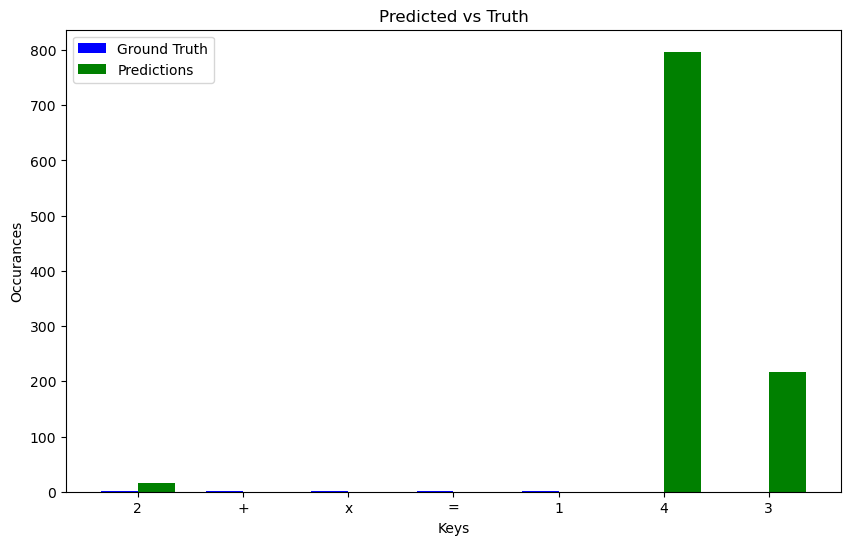

In [55]:
n_epochs = 100
TSD =  TwoStageDetector((480,640), (15, 20), 2048, len(corresp_classes), (2,2))
ll, pred, prop_fin, conf = trainer(TSD, .001, dl, n_epochs)

print(ll)

prop_proj_1 = project_bboxes(prop_fin[0], (iw/fw), (ih/fh), mode='a2p')
classes_g = [idx_2_n[cls] for cls in dl[2].tolist() if cls != -1]
classes_pred_1 = [idx_2_n[cls] for cls in pred[0].tolist() if cls]
nrows, ncols = (1, 2)


# fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))  
# fig = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
guesses = {}
actual = {}
for predict in classes_pred_1:
    if predict in guesses:
        guesses[predict] += 1
    else:
        guesses[predict] = 1

for act in classes_g:
    if act in actual:
        actual[act] += 1
    else:
        actual[act] = 1
        
for key in guesses.keys(): 
    if key not in actual: 
        actual[key]  = 0
for key in actual.keys(): 
    if key not in guesses: 
        guesses[key] = 0 
        
keys = list(actual.keys())  # Assuming keys are the same for both dictionaries
values_dict1 = [actual[key] for key in keys]
values_dict2 = [guesses[key] for key in keys]

# Plotting the double bar graph
plt.figure(figsize=(10, 6))
bar_width = 0.35

# Position of bars on x-axis
r1 = range(len(keys))
r2 = [x + bar_width for x in r1]

# Create bars for both dictionaries
plt.bar(r1, values_dict1, color='b', width=bar_width, label='Ground Truth')
plt.bar(r2, values_dict2, color='g', width=bar_width, label='Predictions')
plt.xlabel('Keys')
plt.ylabel('Occurances')
plt.title('Predicted vs Truth')
plt.xticks([r + bar_width/2 for r in range(len(keys))], keys)
plt.legend()

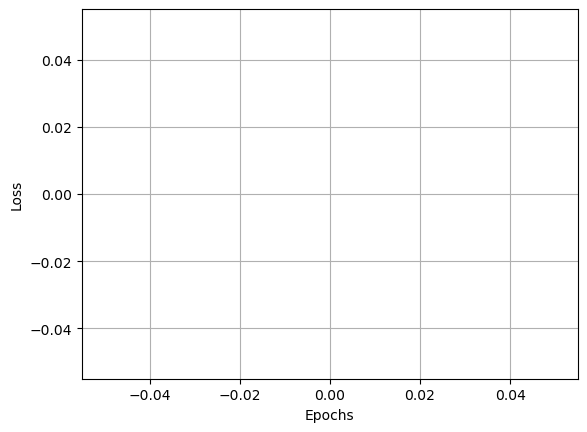

In [25]:
x = np.arange(len(ll))
plt.plot(x, ll, marker='o', linestyle='-', color='b')  # Plot ll vs. x with markers
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.grid(True)  # Show grid
plt.show()

In [ ]:
# project proposals to the image space

# torch.save(TSD.state_dict(), "model.pt")
# TSD.eval()
# proposals_final, conf_scores_final, classes_final = TSD.inference(mini.img_data_all)
# prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
# prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# # get classes
# classes_pred_1 = [idx_2_n[cls] for cls in classes_final[0].tolist()]
# classes_pred_2 = [idx_2_n[cls] for cls in classes_final[1].tolist()]

# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# fig, axes = display_img(mini.img_data_all, fig, axes)
# fig = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# fig = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

In [ ]:
print(classes_pred_1)
print(n_2_idx )